# FOV evaluation for MEMS device using Standard precision FOV device.
<div style="text-align: right;">14th Dec. 2022<div>
<div style="text-align: right;">Shinichiro Sonoda<div>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
title = "SB2110303"

area0 = (1010,1020,1525,1535)
area1 = (1000,1030,1515,1545)

img_array = []
path = "../error/"+title+"/*.png"

files = glob.glob(path)
img_array.append([cv2 . imread (file , 1 ) for file in files])
files

['../error/SB2110303\\1038.png',
 '../error/SB2110303\\1039.png',
 '../error/SB2110303\\1040.png',
 '../error/SB2110303\\1063.png',
 '../error/SB2110303\\1064.png',
 '../error/SB2110303\\1065.png',
 '../error/SB2110303\\1087.png',
 '../error/SB2110303\\1088.png',
 '../error/SB2110303\\1089.png',
 '../error/SB2110303\\1126.png',
 '../error/SB2110303\\1127.png',
 '../error/SB2110303\\1128.png',
 '../error/SB2110303\\1257.png',
 '../error/SB2110303\\1258.png',
 '../error/SB2110303\\1259.png',
 '../error/SB2110303\\1383.png',
 '../error/SB2110303\\1384.png',
 '../error/SB2110303\\1385.png',
 '../error/SB2110303\\2077.png',
 '../error/SB2110303\\2078.png',
 '../error/SB2110303\\2079.png',
 '../error/SB2110303\\2198.png',
 '../error/SB2110303\\2199.png',
 '../error/SB2110303\\2200.png',
 '../error/SB2110303\\2231.png',
 '../error/SB2110303\\2232.png',
 '../error/SB2110303\\2233.png',
 '../error/SB2110303\\673.png',
 '../error/SB2110303\\674.png',
 '../error/SB2110303\\675.png',
 '../error/SB

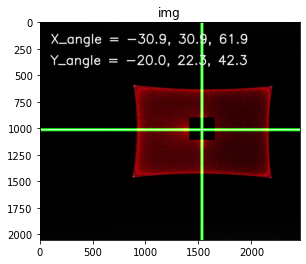

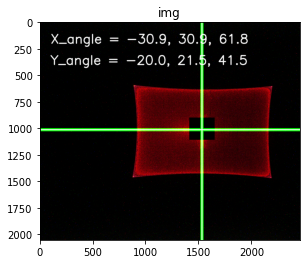

In [3]:
import copy
for i in range(2):
    img = img_array[0][i]
    plt.title("img")
    img_over = copy.deepcopy(img)*5
    
    img_over[:,area1[2]:area1[3],1] = 255
    img_over[:,area0[2]:area0[3],:] = 255
    
    img_over[area1[0]:area1[1],:,1] = 255
    img_over[area0[0]:area0[1],:,:] = 255
    
    
    
    plt.imshow(img_over[:,:,::-1])
    plt.show()
    
    cv2.imwrite('test{}.png'.format(i), img_over)
    

In [4]:
def draw_img_array(img_array, area, title):
    for img in img_array:
        img_x = img[area[0]:area[1],:]
        img_y = img[:,area[2]:area[3]]
        x = np.array(range(img.shape[0]))
        y = np.average(img_y[:,:,2], axis = 1)
        y[0:500] = 0
        plt.plot(x, y)

    plt.xlabel("Position (px)")
    plt.ylabel("Amplitude (/8bit)")
    plt.title(title)
    plt.ylim(0, np.max(y) * 1.2)
    plt.show()

In [5]:
def draw_img_array_zoom(img_array, area, title, x_range):
    for img in img_array:
        img_x = img[area[0]:area[1],:]
        img_y = img[:,area[2]:area[3]]
        x = np.array(range(img.shape[0]))
        y = np.average(img_y[:,:,2], axis = 1)
        y[0:500] = 0
        plt.plot(x, y)
       
    plt.xlabel("Position (px)")
    plt.ylabel("Amplitude (/8bit)")
    plt.title(title)
    plt.xlim(x_range[0], x_range[1]) 
    plt.ylim(0, np.max(y[x_range[0]:x_range[1]]) * 1.2)
    plt.show()

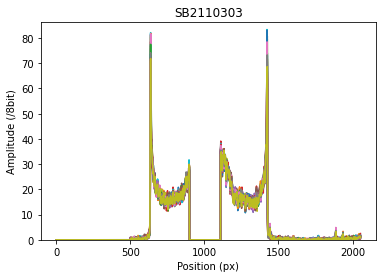

In [6]:
 draw_img_array(img_array[0], area1, title = title)

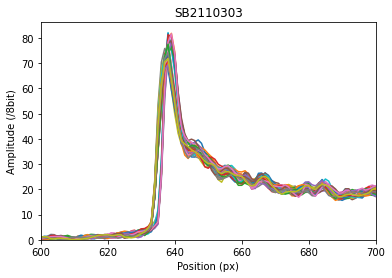

In [7]:
 draw_img_array_zoom(img_array[0], area1, title, (600,700))

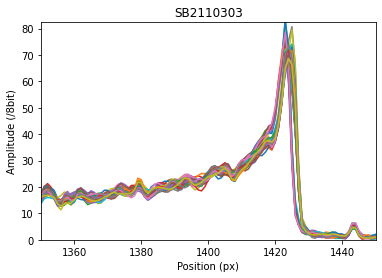

In [8]:
 draw_img_array_zoom(img_array[0], area1, title, (1350,1450))

In [9]:
# edge detection module
def cal_edge(img, th, axis=0, print_flag=False):
    if axis == 0:
        x = np.array(range(img.shape[1]))
    elif axis == 1:
        x = np.array(range(img.shape[0]))
    else:
        return

    y = np.average(img, axis = axis)[:, 2] #Red chanel select
    #y = np.average(img, axis = axis)

    if np.max(y) > 30:
        y = y/np.max(y)
    else:
        y = y * 0
    
    """
    if axis ==1:
        plt.plot(x,y)
        plt.show()
    """
    
    flag  = True
    
    edge0 = np.where((y > th[0]) & (y < th[1]))[0]
    edge1 = np.where((y > th[2]) & (y < th[3]))[0]

    if len(edge0) == 0 or len(edge1) == 0:
        flag = False
    else: 
        edge0 = edge0[0]
        edge1 = edge1[-1]

    if print_flag: 
        print(edge0, edge1)
    
    return (edge0, edge1), flag

# x,y edge detection
def detect_edge(img, area, th =(0.2,0.8,0.2,0.8)):
    img_x = img[area[0]:area[1],:]
    img_y = img[:,area[2]:area[3]]
    
    edge_x, flag0 = cal_edge(img_x, th, axis=0)
    edge_y, flag1 = cal_edge(img_y, th, axis=1)

    return {"edge_x":edge_x, "edge_y":edge_y}, flag0 * flag1

# camera calibration
def X_Pixel_To_Lx(px):
    return 5*10**-6 * px**2 + 0.3703 *px - 583.05

def Y_Pixel_To_Ly(px):
    return 0.3825 *px - 388.46

# distance between 
def L_To_Angle(L, Lz=400):
    return np.rad2deg(np.arctan(L/ Lz))    

# get angle
def Get_Angle(img, area, ignore=[900,1110,1410,1650], axis=0):
    img[ignore[0]:ignore[1], ignore[2]:ignore[3]] = 0
    data, flag = detect_edge(img, area=area)
    if axis == 0 and flag == True:
        Lx_low, Lx_high = X_Pixel_To_Lx(data["edge_x"][0]), X_Pixel_To_Lx(data["edge_x"][1])
        return (L_To_Angle(Lx_low),\
               L_To_Angle(Lx_high),\
               -L_To_Angle(Lx_low) + L_To_Angle(Lx_high)), flag

    elif axis == 1 and flag == True:
        Ly_low, Ly_high = Y_Pixel_To_Ly(data["edge_y"][0]),Y_Pixel_To_Ly(data["edge_y"][1])
        return (L_To_Angle(Ly_low),\
               L_To_Angle(Ly_high),\
               -L_To_Angle(Ly_low) + L_To_Angle(Ly_high)), flag

    else:
        return (0.0, 0.0, 0.0), flag

In [10]:
angle0= []
angle1= []

for img in img_array[0]:
    img[0:500,:,:] = 0
    
    data0, _ = Get_Angle(img, area0, axis=1)
    angle0.append(data0[2])
    
    data1, _ = Get_Angle(img, area1, axis=1)
    angle1.append(data1[2])
    
    #plt.gray()
    #plt.imshow(img[1440:1460,1525:1535, 2])
    #plt.show()    

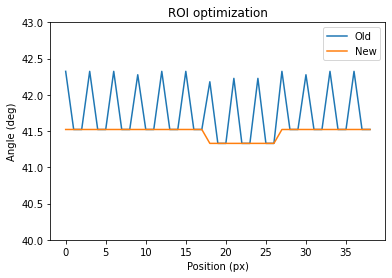

In [11]:
labels =["Old", "New"]

y0 = np.array(angle0)
y1 = np.array(angle1)
x = np.arange(0, len(y0))
plt.xlabel("Position (px)")
plt.ylabel("Angle (deg)")
plt.title("ROI optimization")
plt.ylim(40,43)
plt.plot(x, y0, label = labels[0])
plt.plot(x, y1, label = labels[1])
plt.legend()